# Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from haversine import haversine
from itertools import izip
import csv

# Load Data

In [22]:
column_names = [
    "lat", 
    "lon", 
    "id", 
    "source_id", 
    "account_id", 
    "title", 
    "created_on", 
    "updated_on", 
    "start_ts", 
    "until_ts",
    "report_type",
    "notes", 
    "layer_id",
    "severity"
]

target_columns = [
    "lat",
    "lon",
    "id",
    "title",
    "start_ts",
    "report_type",
    "severity"
]

In [23]:
def severity_score(severity_rating):
    if severity_rating == "low":
        return 1
    elif severity_rating == "moderate":
        return 2
    elif severity_rating == "medium":
        return 3
    elif severity_rating == "high":
        return 4
    elif severity_rating == "extreme":
        return 5
    else:
        return 2
    
def severity_score_quadratic(severity_rating):
    if severity_rating == "low":
        return 1
    elif severity_rating == "moderate":
        return 4
    elif severity_rating == "medium":
        return 9
    elif severity_rating == "high":
        return 16
    elif severity_rating == "extreme":
        return 25
    else:
        return 4
    
def severity_score_log(severity_rating):
    if severity_rating == "low":
        return np.log(1)
    elif severity_rating == "moderate":
        return np.log(2)
    elif severity_rating == "medium":
        return np.log(3)
    elif severity_rating == "high":
        return np.log(4)
    elif severity_rating == "extreme":
        return np.log(5)
    else:
        return np.log(2)
    
def severity_score_exp(severity_rating):
    if severity_rating == "low":
        return np.exp(1)
    elif severity_rating == "moderate":
        return np.exp(2)
    elif severity_rating == "medium":
        return np.exp(3)
    elif severity_rating == "high":
        return np.exp(4)
    elif severity_rating == "extreme":
        return np.exp(5)
    else:
        return np.exp(2)

In [26]:
data_filepath = "../data/DEC_2016_subsample/reports_12DEC16-26DEC16.tsv"

# Load sample dataset
df = pd.read_table(data_filepath, header=None, names=column_names)

# Drop rows with NaNs (this is admittedly ugly and the final model will be much more precise)
df.dropna(axis=0, how="any", inplace=True)

# Drop columns we won't need
df = df[target_columns]

# Convert timestamps from Unix Epoch time to Date Time Groups
df["start_ts"] = pd.to_datetime(df["start_ts"], unit="s", errors="ignore")

# Build severity score columns
df["severity_score"] = df["severity"].map(severity_score)
df["severity_quadratic"] = df["severity"].map(severity_score_quadratic)
# df["severity_log"] = df["severity"].map(severity_score_log)
# df["severity_exp"] = df["severity"].map(severity_score_exp)

# Trim reports from outside the specified date range
start = pd.to_datetime("2016-12-12")
end = pd.to_datetime("2016-12-27")
df = df[df["start_ts"] > start]
df = df[df["start_ts"] < end]

In [27]:
print df.info()
# print df.describe()
# print df.head(1)
# print df.tail()
# print df.loc[:,"notes"][0]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96651 entries, 12 to 127327
Data columns (total 9 columns):
lat                   96651 non-null float64
lon                   96651 non-null float64
id                    96651 non-null object
title                 96651 non-null object
start_ts              96651 non-null datetime64[ns]
report_type           96651 non-null object
severity              96651 non-null object
severity_score        96651 non-null int64
severity_quadratic    96651 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 7.4+ MB
None


# Location

Will need to investigate haversine distance (from pip install haversine) and use that to map cities data from GeoNames to this dataset.

In [28]:
location_df = df[["lat", "lon"]]
location_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96651 entries, 12 to 127327
Data columns (total 2 columns):
lat    96651 non-null float64
lon    96651 non-null float64
dtypes: float64(2)
memory usage: 2.2 MB


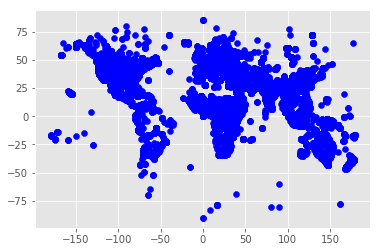

In [29]:
plt.scatter(location_df["lon"], location_df["lat"], color="b")


## Label reports with cities using GeoNames Cities15000 dataset

I explored running a clustering algorithm on the risk reports data to see if it could help define regions I could use for more granular risk thresholds. I used a k Nearest Neighbors model and concluded that k ~= 1000 was ideal. That led me to explore labeling reports to their closest city, and then picking a couple of cities to explore in more depth. 

GeoNames provides a large number of datasets for geolocation, including several for cities around the world (http://download.geonames.org/export/dump/). Cities15000 includes all cities of 15,000 or more and includes a population column. We'll use that to trim down to about 1400 cities by selecting cities of only 300,000 or more.

In [30]:
# Cities15000 column names
city_columns = [
    "geonameid",
    "name",
    "asciiname",
    "alternatenames",
    "latitude",
    "longitude",
    "feature_class",
    "feature_code",
    "country_code",
    "cc2",
    "admin1_code",
    "admin2_code", 
    "admin3_code",
    "admin4_code",
    "population", 
    "elevation",
    "dem",
    "timezone",
    "modification_date",
]

target_city_columns = [
    "asciiname",
    "latitude",
    "longitude",
    "country_code"
]

In [31]:
# I've saved the result of this cell to a separate csv file for easier access later 

# Load Cities15000 dataset
# cities_df = pd.read_table("../data/cities15000.txt", header=None, names=city_columns)

# # Select only medium and larger sized cities and reindex
# cities_df = cities_df[cities_df["population"] > 300000]
# cities_df = cities_df.reset_index()

# # Select only the columns we'll need to label our reports dataset
# cities_df = cities_df[target_city_columns]

# # Relabel name column
# cities_df["name"] = cities_df["asciiname"]
# del cities_df["asciiname"]

# # Save off results for later
# cities_df.to_csv("../data/cities300000.csv", header=True, index=False, mode="w")

# print cities_df.info()
# print cities_df.head()

In [32]:
cities_df = pd.read_csv("../data/cities300000.csv")

print cities_df.info()
print cities_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 4 columns):
latitude        1375 non-null float64
longitude       1375 non-null float64
country_code    1375 non-null object
name            1375 non-null object
dtypes: float64(2), object(2)
memory usage: 43.0+ KB
None
   latitude  longitude country_code            name
0  25.06570   55.17128           AE           Dubai
1  25.33737   55.41206           AE         Sharjah
2  24.19167   55.76056           AE          Al Ain
3  24.46667   54.36667           AE       Abu Dhabi
4  36.70904   67.11087           AF  Mazar-e Sharif


### Compute Haversine Distances

Now that we've got that data cleaned up we can start working on labeling the time series data. The first thing to consider is how we'll actually label the cities. The best way to do this is to calculate the haversine distances (https://en.wikipedia.org/wiki/Haversine_formula) from each report to each city, and label that report with the city with the smallest haversine distance. 

The haversine formula installed by pip takes takes two tuples of lat/long pairs and returns the distance in kilometers between those two points. We'll need to make sure we have an extra column to store latitude and longitude as tuples in each dataframe, so let's do that now.

In [33]:
df["lat_long"] = zip(df["lat"], df["lon"])
cities_df["lat_long"] = zip(cities_df["latitude"], cities_df["longitude"])

### Apply Labels

Easy enough. Now for the labeling. The next cell is brute force caclulating about 1 billion haversine distances and will take quite some time to run. I've saved the indices to a csv file for convenience.

In [34]:
# Build a series of indices of shortest haversine distances. 
# Skip this and the next cell to save time.

# city_label_indices = []
# for report in df["lat_long"]:
#     distances = [haversine(report, city) for city in cities_df["lat_long"]]
#     city_label_indices.append(np.argmin(distances))

# indices_df = pd.DataFrame(city_label_indices)
# indices_df.to_csv("../data/city_label_indices.csv", header=False, mode="w")

In [35]:
# Generate city labels from our indices
# city_labels = []
# for index in city_label_indices:
#     city_labels.append(cities_df.ix[index, "name"])

In [36]:
city_labels = pd.read_csv("../data/DEC_2016_subsample/DEC_city_labels.csv", header=None)

In [37]:
# Apply the labels to our reports
df["city"] = city_labels[1].values
print df.head()

         lat        lon                      id  \
12  47.60621 -122.33207  YpRVi2vA5hG3KaECZNc2RA   
19  10.88942   13.62832  BOp0T5XA5hGpGhrRy13KCQ   
20  30.00000   70.00000  pB5pNJfA5hGCeqQCZNc2RA   
21 -38.65333  178.00417  NHdcOpfA5hGjdqQCZNc2RA   
22  45.50032  -69.24977  Ql77PJfA5hGDH6QCZNc2RA   

                                                title            start_ts  \
12                                No longer forgotten 2016-12-12 13:04:41   
19  OSINT Summary: Suicide attacks in northeast Ni... 2016-12-12 18:03:39   
20         Name of cyclone 'Vardah' given by Pakistan 2016-12-12 18:17:13   
21     Plane crash and situation in Gisborne – UPDATE 2016-12-12 18:17:23   
22  Winter storm warning, advisory issued for Mond... 2016-12-12 18:17:27   

         report_type  severity  severity_score  severity_quadratic  \
12  Physical Threats  moderate               2                   4   
19  Physical Threats    medium               3                   9   
20      Geopolitical

And we're set! We'll be looking at a couple of European cities through the rest of this exploration (Berlin, Paris, and London).

## Get Dummy Columns

Adding categorical dummy columns for city, type, and severity

In [38]:
sev_dum = pd.get_dummies(df["severity"])
city_dum = pd.get_dummies(df["city"])
type_dum = pd.get_dummies(df["report_type"])
print sev_dum.describe()
print city_dum.describe()
print type_dum.describe()

       (PHOTOS)</a>       extreme          high  interim measure</a>  \
count  96651.000000  96651.000000  96651.000000         96651.000000   
mean       0.000010      0.049456      0.021024             0.000010   
std        0.003217      0.216820      0.143465             0.003217   
min        0.000000      0.000000      0.000000             0.000000   
25%        0.000000      0.000000      0.000000             0.000000   
50%        0.000000      0.000000      0.000000             0.000000   
75%        0.000000      0.000000      0.000000             0.000000   
max        1.000000      1.000000      1.000000             1.000000   

                low        medium      moderate       unrated  
count  96651.000000  96651.000000  96651.000000  96651.000000  
mean       0.012209      0.154453      0.761544      0.001293  
std        0.109818      0.361384      0.426141      0.035940  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.0000

In [39]:
merge_test = pd.merge(df, sev_dum, left_index=True, right_index=True)
merge_test = pd.merge(merge_test, city_dum, left_index=True, right_index=True)
merge_test = pd.merge(merge_test, type_dum, left_index=True, right_index=True)

print merge_test.info()
print merge_test.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96651 entries, 12 to 127327
Columns: 1040 entries, lat to riskline_7
dtypes: datetime64[ns](1), float64(2), int64(2), object(6), uint8(1029)
memory usage: 106.2+ MB
None
                lat           lon  severity_score  severity_quadratic  \
count  96651.000000  96651.000000    96651.000000        96651.000000   
mean      29.366763      8.185640        2.332661            6.026508   
std       20.831201     77.570747        0.764988            4.970152   
min      -90.000000   -179.966700        1.000000            1.000000   
25%       21.433330    -76.905670        2.000000            4.000000   
50%       35.000000     21.093750        2.000000            4.000000   
75%       41.000185     70.000000        2.000000            4.000000   
max       85.000000    179.416670        5.000000           25.000000   

       (PHOTOS)</a>       extreme          high  interim measure</a>  \
count  96651.000000  96651.000000  96651.000000   

## Time Series Exploration (Berlin)

This time series is centered on the Berlin market attack of 19 1902Z DEC 2016 (that's 7:02 PM UTC, 8:02 PM local time, on December 19th, 2016). The goal of the project is to detect likely incidents through anomolies in reporting as quickly as possible so Stabilitas customers can take appropriate action to stay safe. So let's see what the time series looks like for Berlin over this two week period.

###### NB: All timestamps are stored as Unix epoch time in UTC

In [34]:
attack_dtg = "2016-12-19 19:02:00"

In [35]:
def get_city_df(df, city):
    return df[df["city"] == city]

In [36]:
def get_city_timeseries(df, city):
    city_df = df[df["city"] == city]
    reports_ts = pd.Series(np.ones(len(city_df)), index=city_df["start_ts"])
    severity_ts = pd.Series(city_df["severity_score"].values, index=city_df["start_ts"])
    quadratic_ts = pd.Series(city_df["severity_quadratic"].values, index=city_df["start_ts"])
    
    return reports_ts, severity_ts, quadratic_ts

In [37]:
# This cell is adapted from a Galvanize lecture on time series.
# Credit to Matt Drury and Jack Benetto.

def fit_moving_average_trend(series, window=6):
    return series.rolling(window=window, min_periods=1, center=False).mean()

def fit_moving_std_trend(series, window=6):
    return series.rolling(window=window, min_periods=1, center=False).std()

def plot_moving_std_trend(ax, name, data_series, window=6):
    moving_average_trend = fit_moving_average_trend(data_series, window)
    moving_std_trend = fit_moving_std_trend(data_series, window)
    ax.scatter(
        data_series.index, 
        data_series.values, 
        color="r"
    )
    ax.plot(
        data_series.index, 
        moving_average_trend, 
        color="K", 
        alpha=0.7)
    ax.fill_between(
        moving_average_trend.index, 
        moving_average_trend+moving_std_trend, 
        moving_average_trend, 
        color="k", alpha=0.2)
    ax.fill_between(
        moving_average_trend.index, 
        moving_average_trend+2*moving_std_trend, 
        moving_average_trend+moving_std_trend, 
        color="y", alpha=0.2)
    ax.fill_between(
        moving_average_trend.index, 
        moving_average_trend+3*moving_std_trend, 
        moving_average_trend+2*moving_std_trend, 
        color="c", alpha=0.2)
    
    ax.set_title(name)
    ax.set_xlabel("Time")
    ax.set_ylabel("Risk")

In [38]:
cities = ["Aleppo", "Berlin", "Kayseri", "Amman", "Ankara", "Mexico City", "Jerusalem"]

# The cities below appear as critical because reports for their country as a whole get 
# mapped only to that city. I will need to do some more work to account for this. 

# cities = ["Wichita", "Tianshui"]

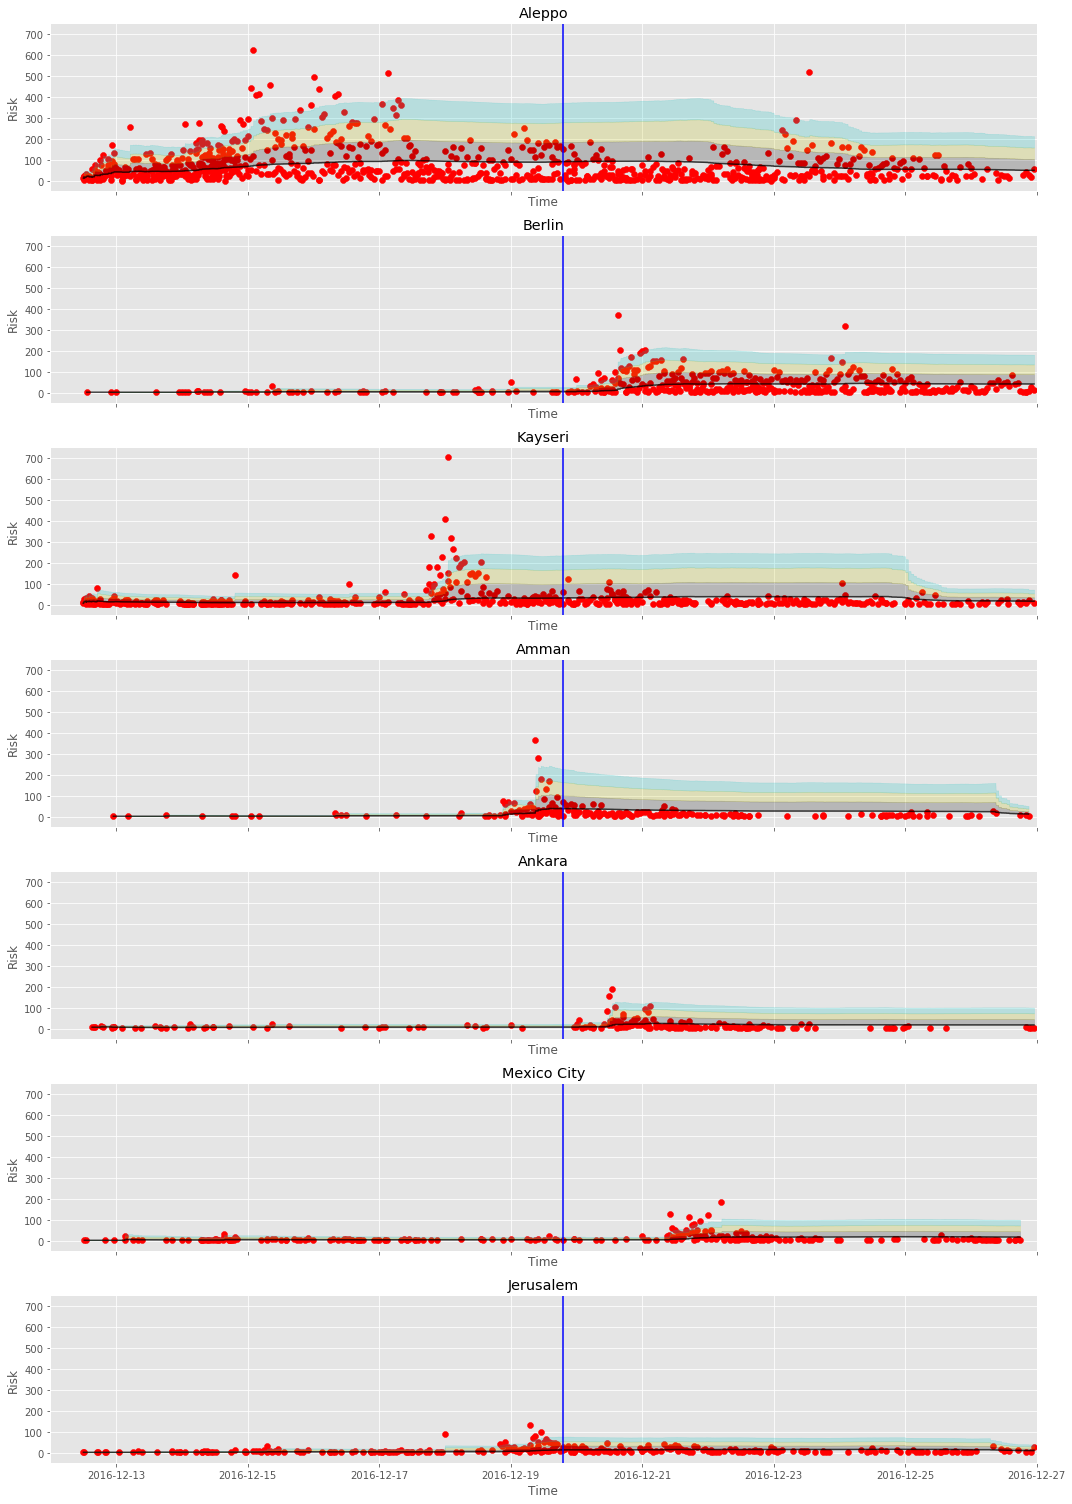

In [44]:
fig, axes = plt.subplots(len(cities),
                         figsize=(15,3*len(cities)),
                         sharex=True,
                         sharey=True
                        )

for i, ax in enumerate(axes):
    volume, severity, quadratic = get_city_timeseries(df, cities[i])
    resample = quadratic.resample("5T").sum()
    plot_moving_std_trend(ax,
                          name=cities[i],
                          data_series=resample,
                          window=(7*24*60)/5)
    ax.axvline(attack_dtg, color="b")
    
plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

In [42]:
berlin_df = df[df["city"] == "Berlin"]

print berlin_df.head()
print berlin_df.info()

           lat       lon                      id                 source_id  \
628   52.52437  13.41053  jgv8tk3D5hGHldQN+RcZ4Q  5852e6184d49f935edb2c196   
1027  52.52437  13.41053  Rp32H0jG5hGeDkcO+RcZ4Q  585853114d49f951da1827fe   
1087  52.52437  13.41053  tlLR987G5hG0UQvRy13KCQ  585891574d49f925967b9ef2   
1124  52.52437  13.41053  crlXDwnH5hGdLAzRy13KCQ  585942884d49f972c9902cdc   
1133  52.52437  13.41053  fItRSAnH5hGMB9kN+RcZ4Q  5858e0684d49f92282a599fb   

     account_id                                              title  \
628      GLOBAL   Berlin Borough prepping for planned power outage   
1027     GLOBAL  Truck runs into crowded Christmas market in Be...   
1087     GLOBAL  9 killed, 50 injured in Berlin in apparent tru...   
1124     GLOBAL  Truck terror strikes Germany and European tourism   
1133     GLOBAL  Truck crashed into Berlin market ‘intentionall...   

      created_on  updated_on            start_ts    until_ts  \
628   1481864934  1481864923 2016-12-16 05:08:

In [43]:
start_timeseries = pd.Series(np.ones(len(berlin_df)), index=berlin_df["start_ts"])
ts = start_timeseries["2016-12-12":"2016-12-27"]


In [44]:
daily = ts.resample("d").sum()
hourly = ts.resample("H").sum()
five_mins = ts.resample("5T").sum()
weekly = ts.resample("7d").sum()

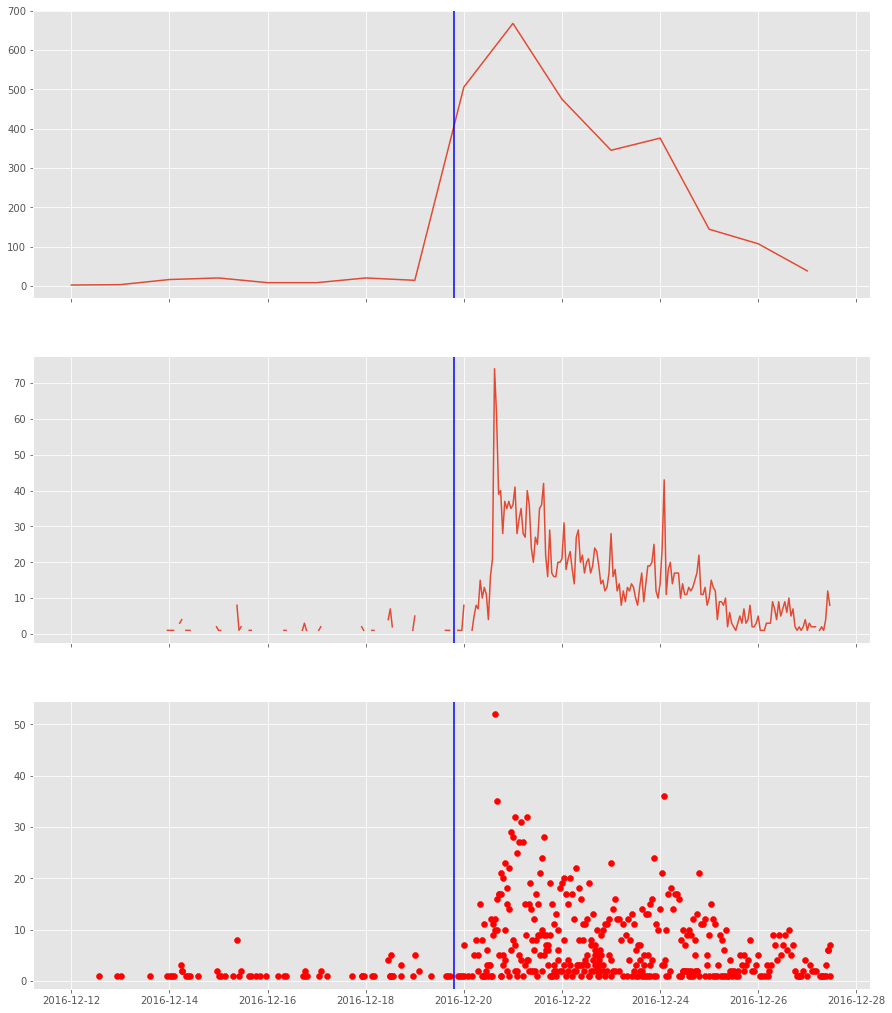

In [45]:
fig, axes = plt.subplots(3, figsize=(15,18), sharex=True)
axes[0].plot(daily)
axes[0].axvline(attack_dtg, color="b")
axes[1].plot(hourly)
axes[1].axvline(attack_dtg, color="b")
axes[2].scatter(five_mins.index, five_mins.values, color="r")
axes[2].axvline(attack_dtg, color="b")

Seems like Berlin was pretty quiet leading up to the attack. Let's look at the 19th and 20th a little more closely.

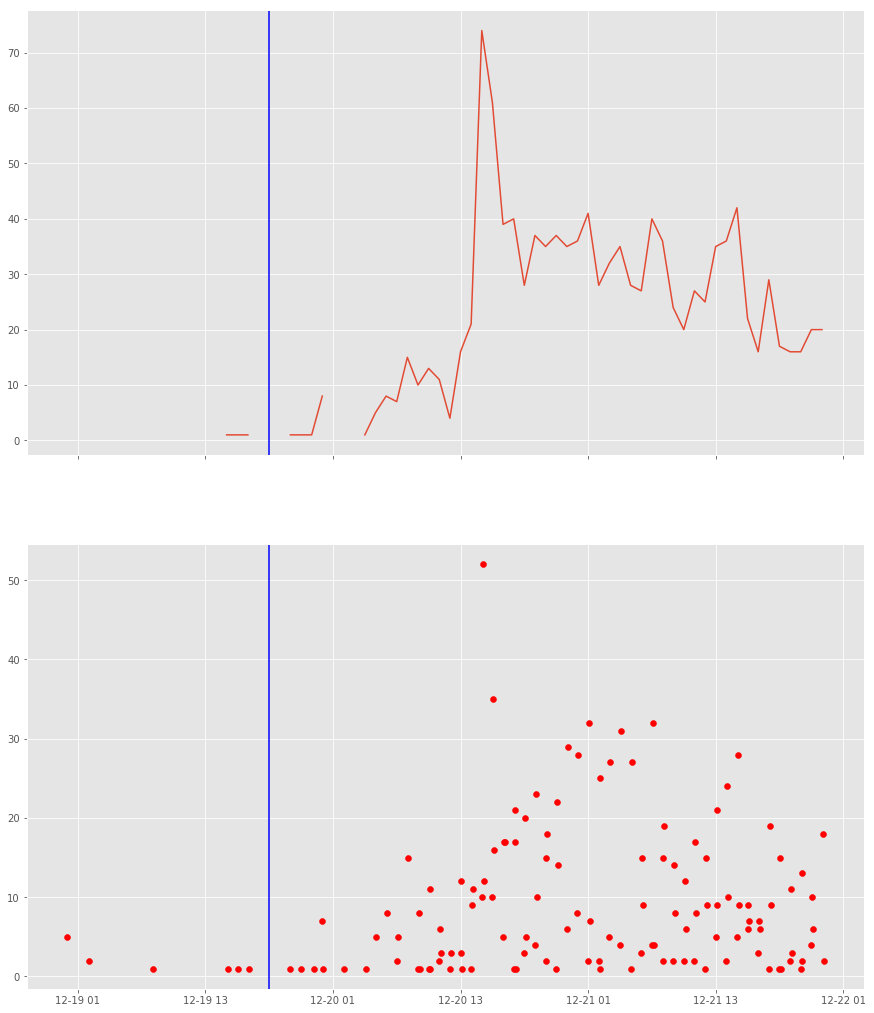

In [46]:
two_day = start_timeseries["2016-12-19":"2016-12-21"]

td_daily = two_day.resample("d").sum()
td_hourly = two_day.resample("H").sum()
td_five_mins = two_day.resample("5T").sum()
fig, axes = plt.subplots(2, figsize=(15,18), sharex=True)

axes[0].plot(td_hourly)
axes[1].scatter(td_five_mins.index, td_five_mins.values, color="r")
axes[0].axvline(attack_dtg, color="b")
axes[1].axvline(attack_dtg, color="b")

That first blip after the attack is where I'd like to be able to detect that something serious has happened. Now that we can see there's a blip there before the giant spike from the next day, let's see what we can do to pull that out from the random noise.

At this point it's may be helpful for a quick aside to see why I'm plotting the 5-minute volumes. Below I've plotted the data over the entire two weeks across a range of resampling intervals

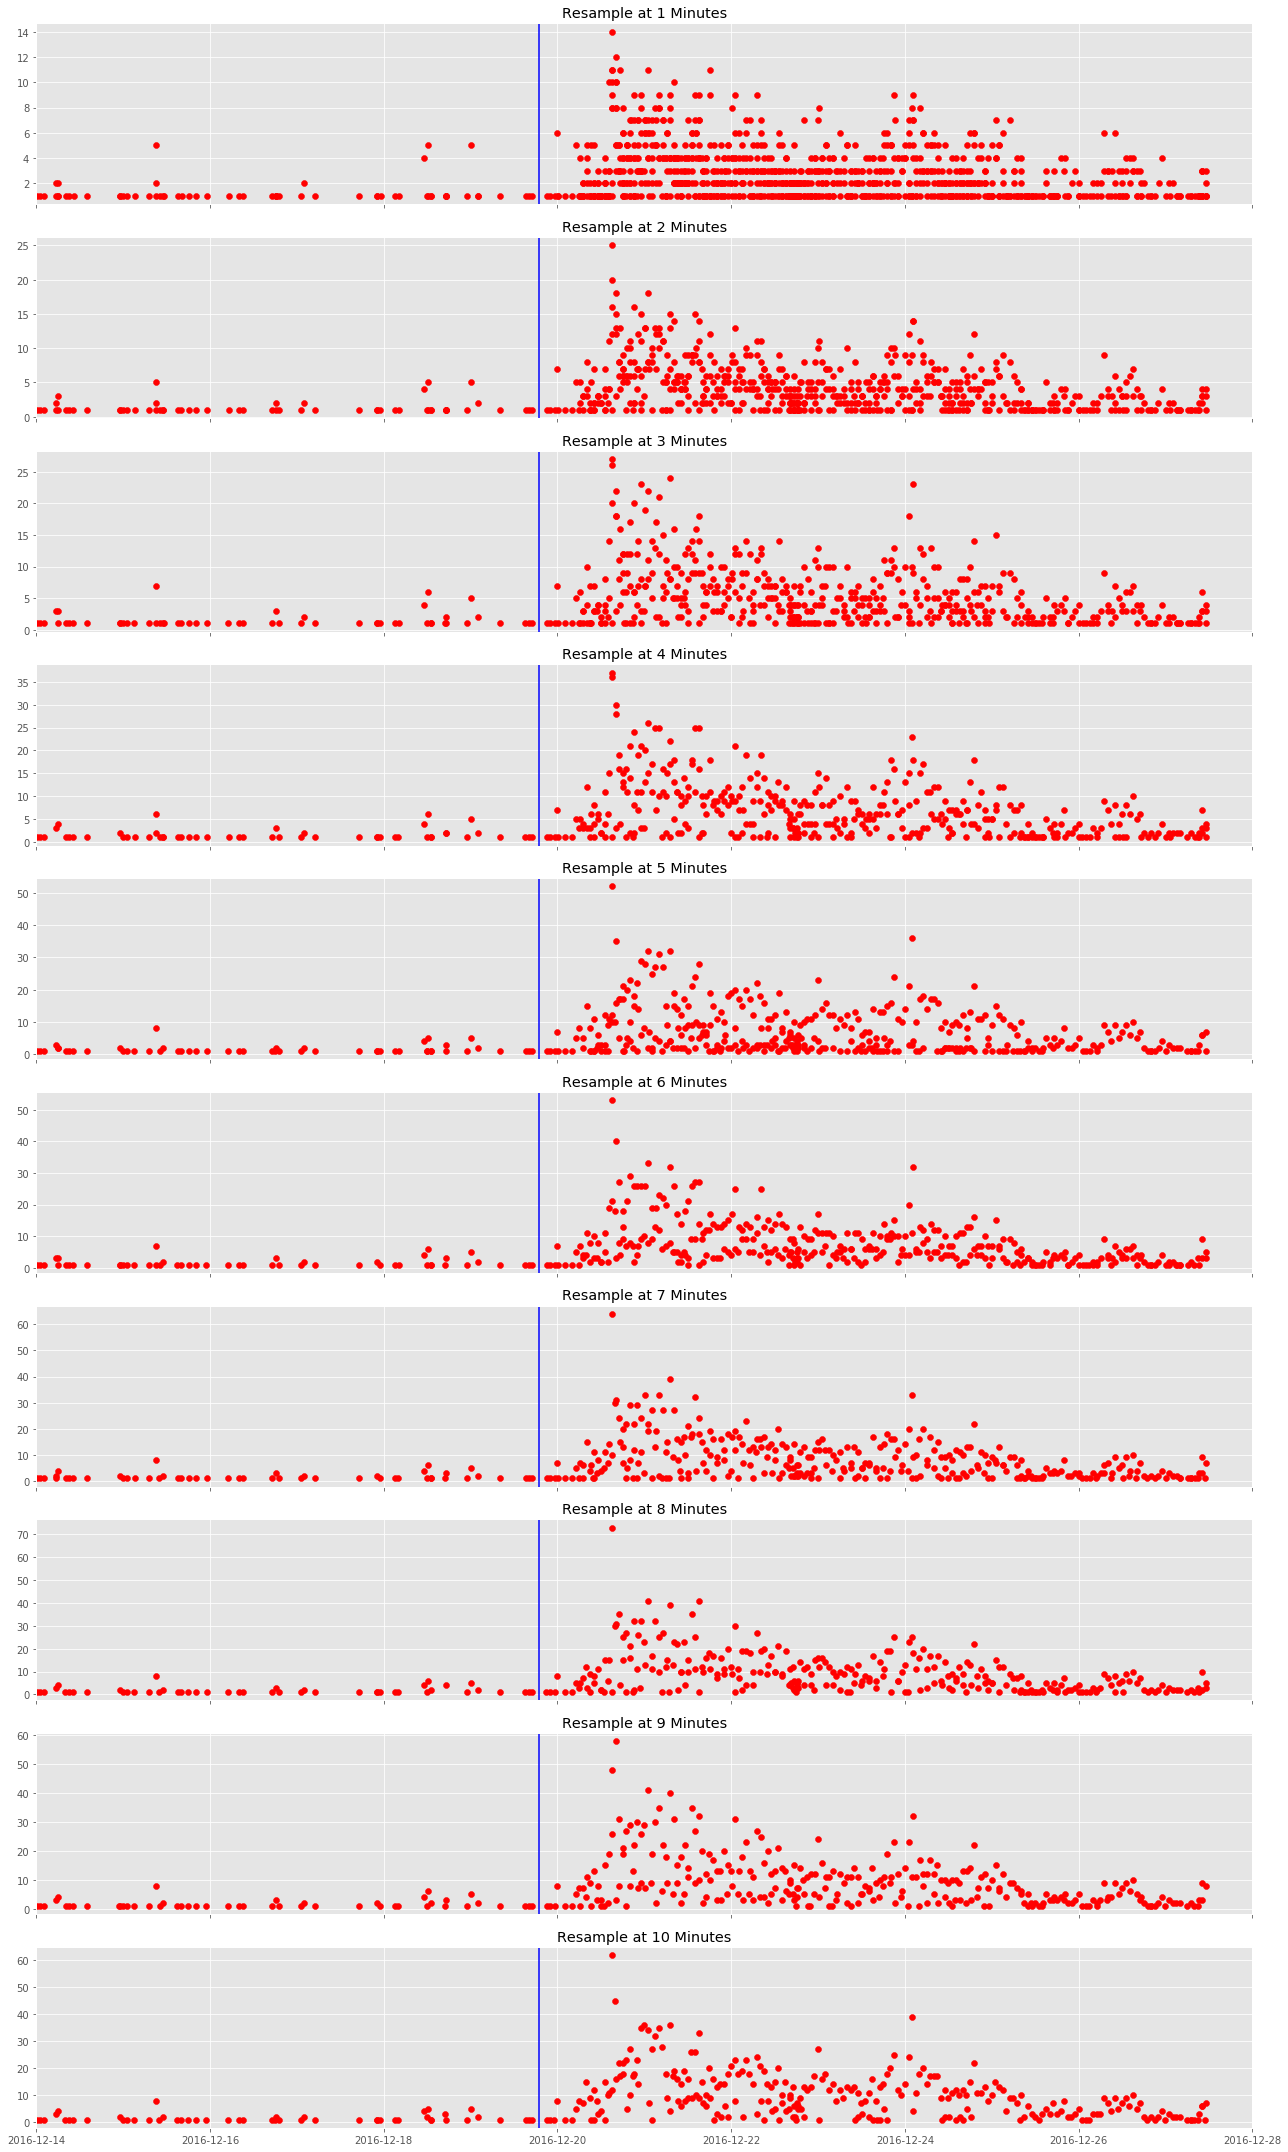

In [47]:
fig, axes = plt.subplots(10, figsize=(18,30), sharex=True)
for i, ax in enumerate(axes.flatten()):
    sampler = ts.resample("{}T".format(i+1)).sum()
    ax.scatter(sampler.index, sampler.values, color="r")
    ax.set_title("Resample at {} Minutes".format(i+1))
    ax.axvline(attack_dtg, color="b")
    
plt.xlim("2016-12-14", "2016-12-28")
plt.tight_layout()

There's banding and a lot of noise for anything less than 5 minutes. Time intervals greater than 5 minutes improve the signal of extreme data, but timeliness is critical for this application. Tuning will be required to get this dialed in.

### Sidebar

Also of note, time series are usually plotted as lines, not scatter plots. This series has some gaps and a lot of variance, however, which combine to make scatter plots much more effective. Comparison below.

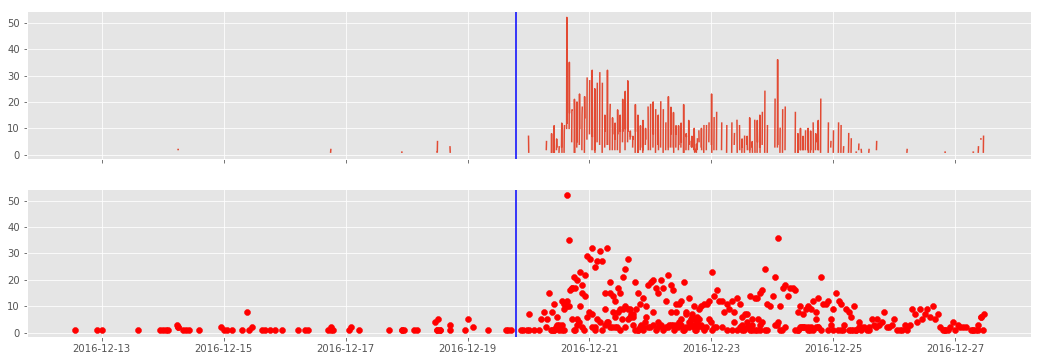

In [48]:
fig, axes = plt.subplots(2, figsize=(18,6), sharex=True)
# plt.title("Comparison of line and scatter plots, 10 minute resampling")
axes[0].plot(five_mins)
axes[0].axvline(attack_dtg, color="b")
axes[1].scatter(five_mins.index, five_mins.values, color="r")
axes[1].axvline(attack_dtg, color="b")

### Back to the time series

It seems like a timescale of 5-7 minutes is going to be ideal, so we'll focus on that and work with 5 minutes for now. Let's look at a moving average for our time series, as that will likely be our key to setting thresholds.

We'll start by comparing some different window sizes.

Let's see what that looks like with moving averages from on day and one week (we'll examine even longer periods later, but for now we've just got two weeks to work with.

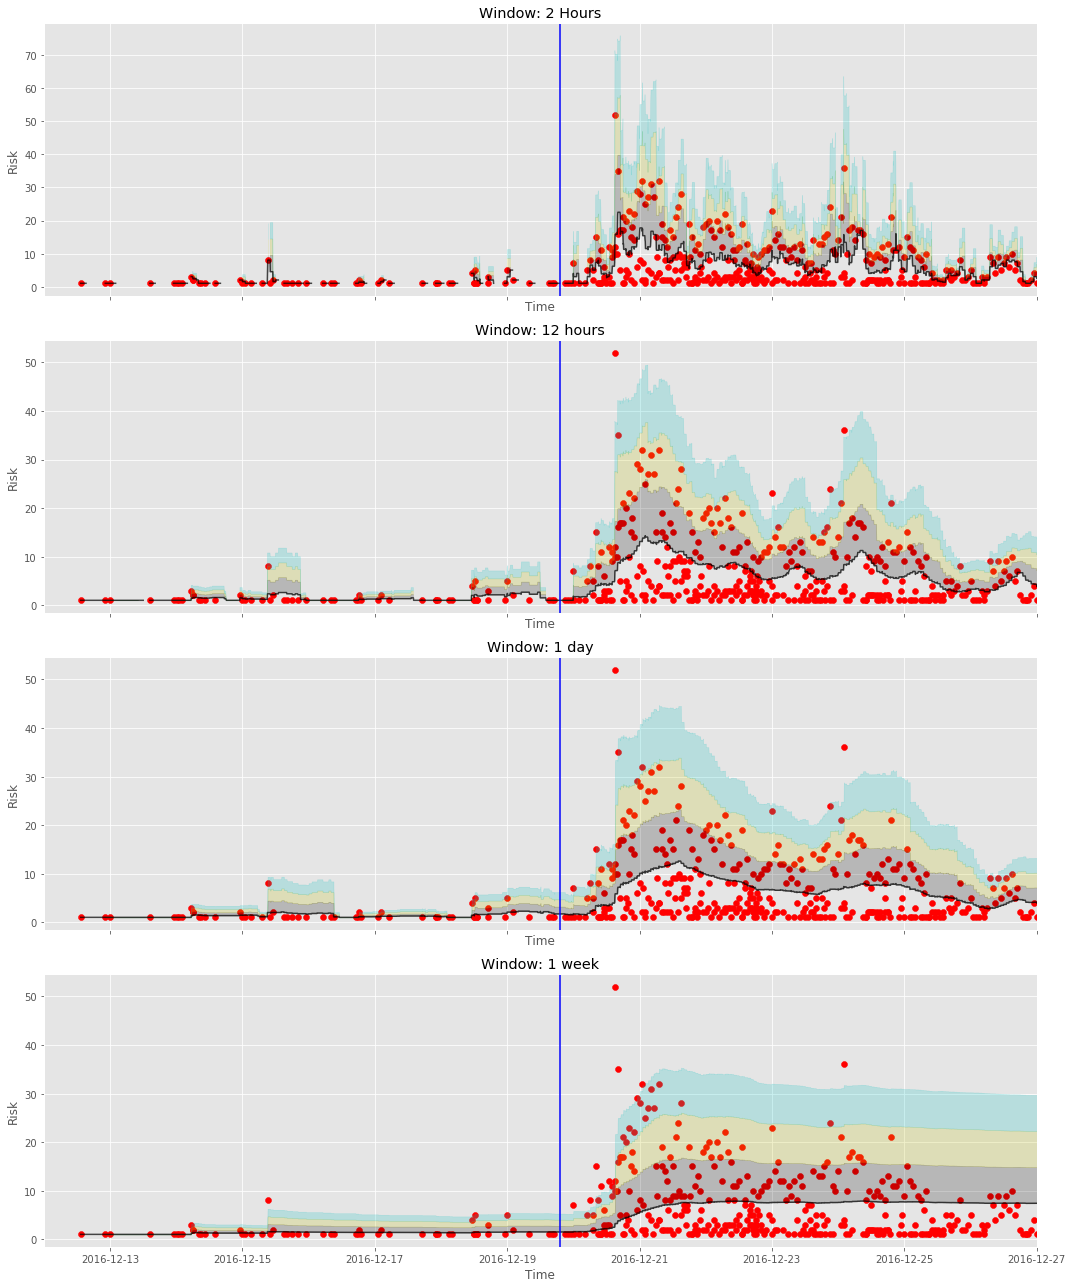

In [49]:
fig, axs = plt.subplots(4, figsize=(15,18), sharex=True)

plot_moving_std_trend(
    axs[0],
    name="Window: 2 Hours",
    data_series=five_mins,
    window=60*2/5
)
axs[0].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[1],
    name="Window: 12 hours",
    data_series=five_mins,
    window=12*60/5
)
axs[1].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[2],
    name="Window: 1 day",
    data_series=five_mins,
    window=24*60/5
)
axs[2].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[3],
    name="Window: 1 week",
    data_series=five_mins,
    window=7*24*60/5
)
axs[3].axvline(attack_dtg, color="b")

plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

Let's get a little close look at two of those

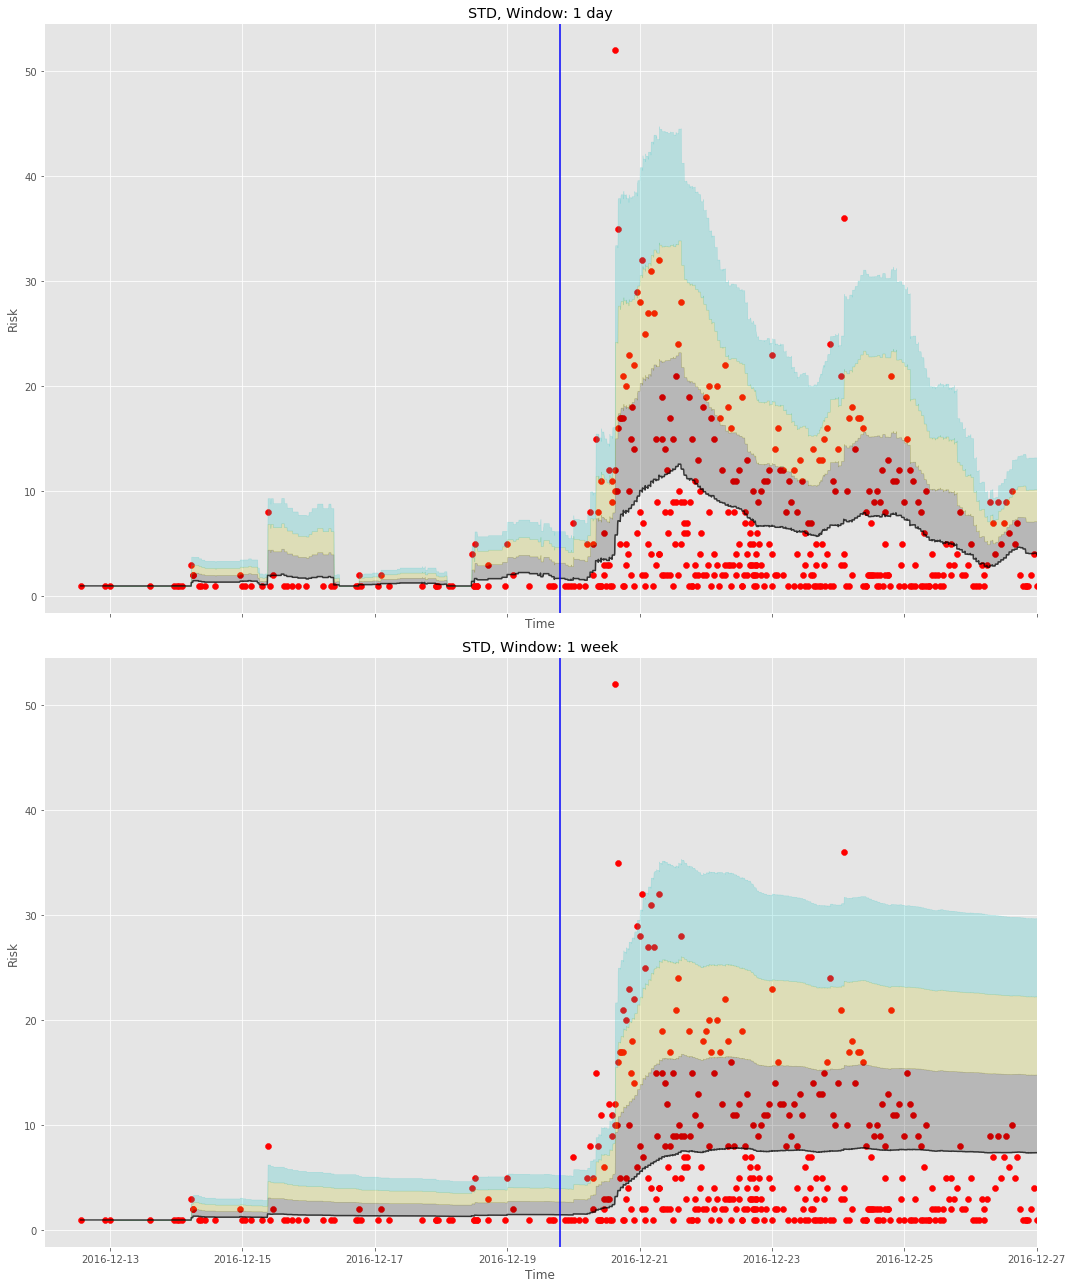

In [50]:
fig, axs = plt.subplots(2, figsize=(15,18), sharex=True)

plot_moving_std_trend(
    axs[0],
    name="STD, Window: 1 day",
    data_series=five_mins,
    window=24*60/5
)
axs[0].axvline(attack_dtg, color="b")

plot_moving_std_trend(
    axs[1],
    name="STD, Window: 1 week",
    data_series=five_mins,
    window=7*24*60/5
)
axs[1].axvline(attack_dtg, color="b")

plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

There are some really useful things here. We can use our rolling standard deviation and mean as simple classifiers for elevated risk level. More importantly, we can use some more sophisticated techniques on the data from points that get flagged as elevated to predict the probability of much greater activity in the near future.

To be clear, this model would not be able to predict serious incidents themselves. Rather, it would use data from anomalous report volumes to calculate the porbability that those reports have come from a serious event.

# Conclusions from Initial EDA

We've looked at the data pretty thoroughly and at this point I think we know enough to move to some preliminary modeling. To review:

We'll proceed with a two-layered model. 

The first layer will flag any grouped datapoints that are one rolling standard deviation above the rolling mean as elevated risk. This flag should be persisted for a while once it's created, but that decision should include stakeholder and customer feedback. My sense is that 4-6 hours is about right.

The second layer will investigate the flagged reports. It will calculate the probability that each of the reports it investigates is indicative of a major event, like the Berlin attack we explored here. I don't have explicitly labeled data to train this model, but I think there are some efficient ways to work around that. 

In order to make this work, we need to prepare our data appropriately. This includes clustering reports to their nearest medium+ sized city and grouping them into useable time series. 

# Appendices

## K means clustering model

This unsupervised learning was intended to explore "regionality" of the risk data. Since I am not using this clustering to predict anything this will likely not play a role in the final model. Clustering based on location may be useful in a production model for other uses though.


I've evaluated each model by its silhouette score (https://en.wikipedia.org/wiki/Silhouette_(clustering)). Values range from -1 to 1, with higher values indicating that points are BOTH very similar to their own cluster AND dissimilar from their neighboring clusters.

##### The cell below takes a long time to run, so I've stored the scores resulting from the grid search for convenience

[0.623, 0.692, 0.831, 0.88]


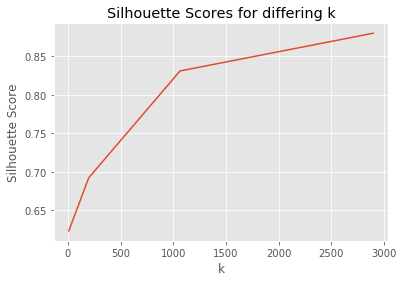

In [51]:
# Load lat/long pairs into numpy
X = location_df.values

# Split data and run on test set.
# The train set is too large to handle locally.
X_train, X_test = train_test_split(X)

# max_clusters = range(2, 21)
# best score from above at 2 (0.66), then at 7 (0.62)

# max_clusters = [100, 150, 200, 250, 300, 350, 400, 450, 500]
# best score from above at 500 (0.77)

# max_clusters = [2, 50, 100, 500, 1000, 5000]
# 5000 clusters takes a LONG time locally (~15 mins).
# Scores: 0.659, 0.535, 0.599, 0.773, 0.824, 0.872

# max_clusters = [600, 800, 1000, 1200, 1400]
# Scores: 0.789, 0.811, 0.827, 0.838, 0.846

# K = num continents, num countries, num cities 500k+, num cities 150k+
max_clusters = [7, 196, 1063, 2896]
# Scores: 0.623, 0.692, 0.831, 0.880
scores = [0.623, 0.692, 0.831, 0.880]

# scores = []
# for k in max_clusters:
#     print "Calculating with {} clusters...".format(k)
#     print "          ...fitting...          "
    
#     model = KMeans(n_clusters=k).fit(X_test)
#     print "          ...scoring...          "
    
#     score = silhouette_score(
#         X_test, 
#         model.predict(X_test), 
#         metric="euclidean"
#     )
    
#     scores.append(score)
#     print "{0} cluster silhouette score = {1}".format(k, score)

print scores

plt.plot(max_clusters, scores)
plt.title("Silhouette Scores for differing k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

### Grid Search results for k

From a grid search, exploratory perspective it seems k is optimal at around 1000, at least when evaluating by silhouette score. Optimizing to meet other criteria (e.g. a different score metric or to conform to real world situations) may yield different results. Below is the chart for silhouette scores from 2 to 5000 clusters.

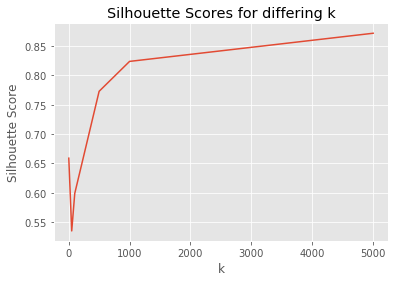

In [52]:
# Plot results from widest grid search
plt.plot(
    [2, 50, 100, 500, 1000, 5000], 
    [0.659, 0.535, 0.599, 0.773, 0.824, 0.872],
)
plt.title("Silhouette Scores for differing k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

## Time Series of the Global Data

Two candidates for time series work, created and start_ts. We will work with start_ts as that indicates the time the report will start being displayed on the Stabilitas app, but this compares the time series data from both

In [55]:
start_timeseries = pd.Series(np.ones(len(df)), index=df["start_ts"])
global_ts = start_timeseries["2016-12-12":"2016-12-27"]

In [56]:
global_daily = global_ts.resample("d").sum()
global_hourly = global_ts.resample("H").sum()
global_ten_mins = global_ts.resample("10T").sum()

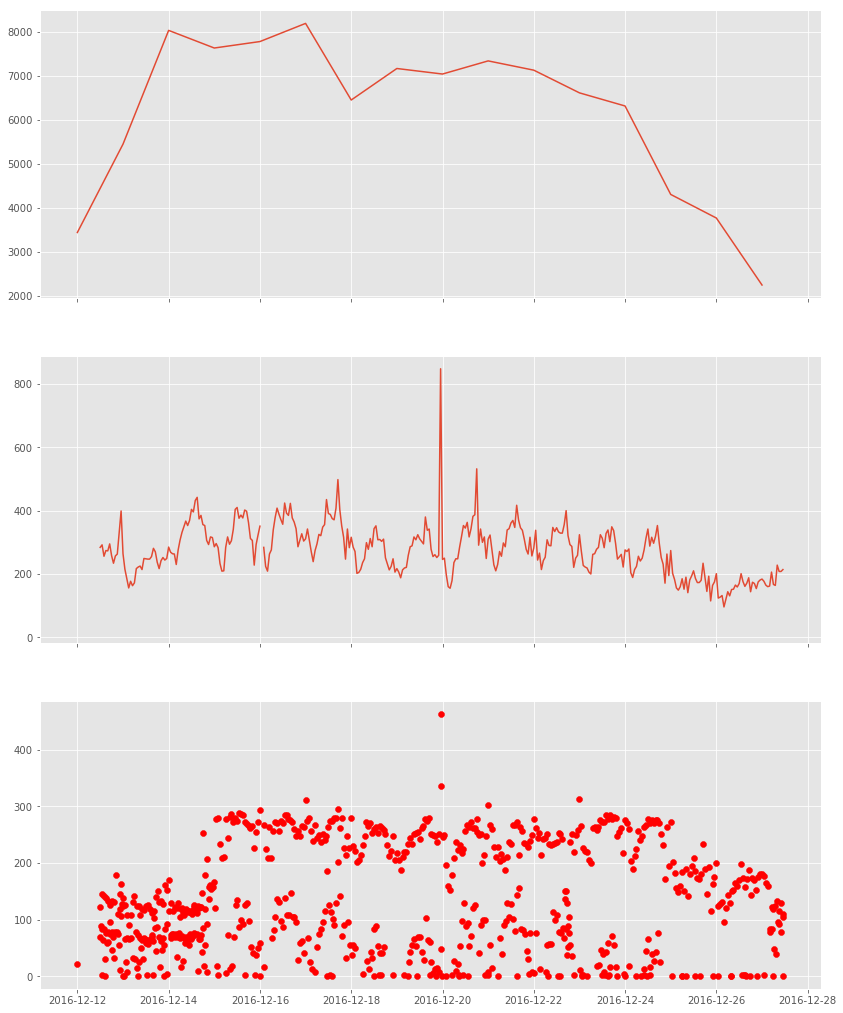

In [57]:
fig, axes = plt.subplots(3, figsize=(14,18), sharex=True)
axes[0].plot(global_daily)
axes[1].plot(global_hourly)
axes[2].scatter(global_ten_mins.index, global_ten_mins.values, color="r")

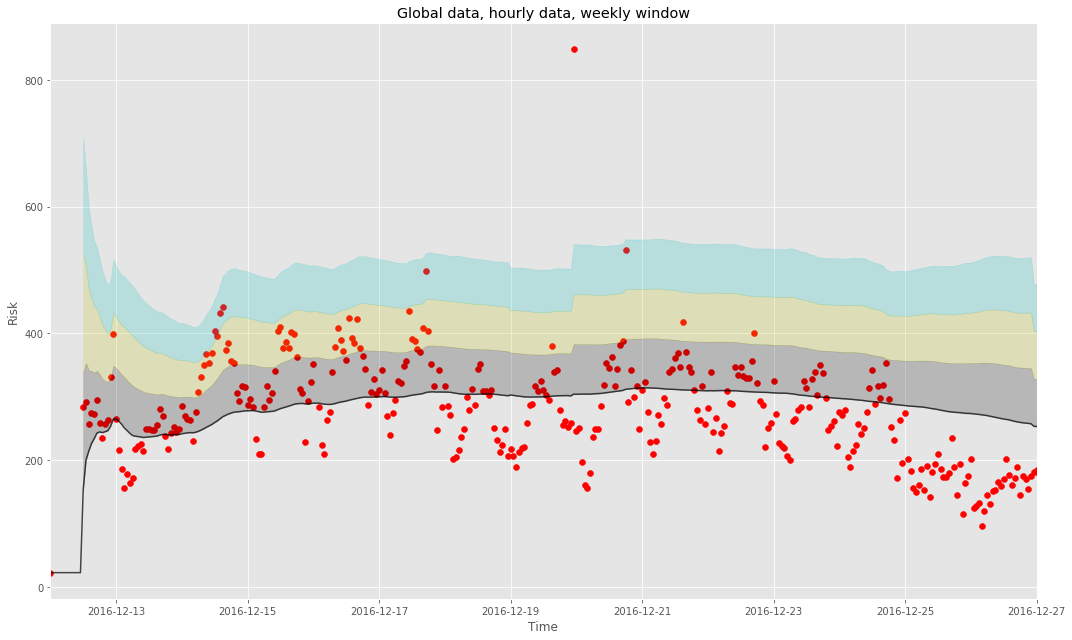

In [58]:
fig, ax = plt.subplots(1, figsize=(15,9))
plot_moving_std_trend(
    ax, 
    name="Global data, hourly data, weekly window", 
    data_series=global_hourly, 
    window=24*7
)
plt.xlim("2016-12-12", "2016-12-27")
plt.tight_layout()

## Unpacking Anomalies

In [59]:
def find_anomalies(series, window):
    rolling_std = fit_moving_std_trend(series, window=window)
    rolling_mean = fit_moving_average_trend(series, window=window)
    threshold = np.add(rolling_mean, rolling_std)
    anomalies = [point[0] if point[0] > point[1] else None for point in izip(series, threshold)]
    
    return pd.Series(anomalies, index=series.index)

def plot_anomalies(ax, 
                   anomalies_series,
                   name,
                   date_range=("2016-12-12","2016-12-27"), 
                   vline="2016-12-19 19:02:00"):
    ax.scatter(anomalies_series.index, anomalies_series.values)
    ax.set_xlim(date_range)
    ax.axvline(vline, color="b")
    ax.set_title(name)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of Reports")

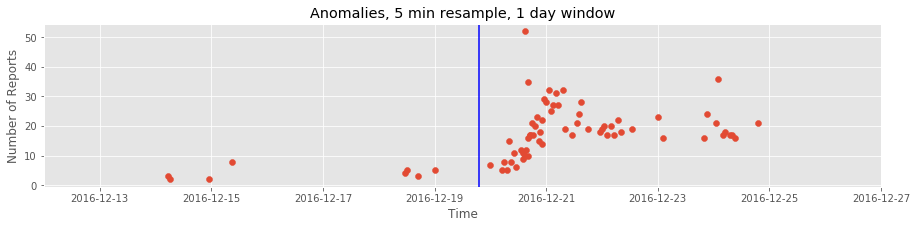

In [60]:
five_mins_anomalies = find_anomalies(five_mins, window=(7*24*60)/5)

fig, ax = plt.subplots(1, figsize=(15,3))

plot_anomalies(ax, five_mins_anomalies, name="Anomalies, 5 min resample, 1 day window")

In [61]:
one_min = ts.resample("T").sum()
two_mins = ts.resample("2T").sum()
three_mins = ts.resample("3T").sum()
four_mins = ts.resample("4T").sum()

resample_options = [one_min, two_mins, three_mins, four_mins, five_mins]

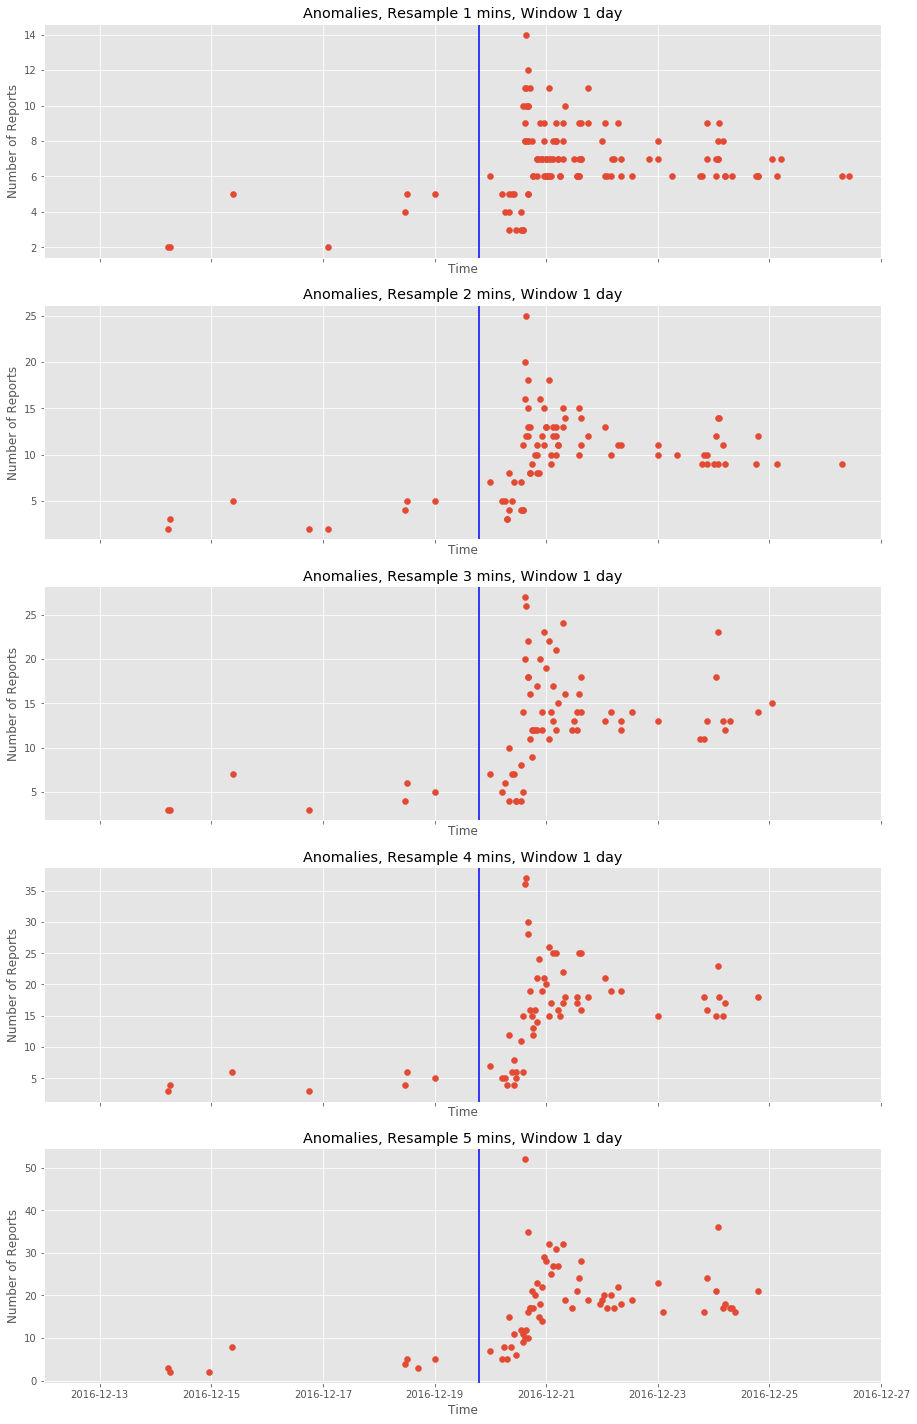

In [62]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for i, ax in enumerate(axes.flatten()):
    anomalies = find_anomalies(resample_options[i], window=(7*24*60)/(i+1))
    plot_anomalies(ax, anomalies, name="Anomalies, Resample {} mins, Window 1 day".format(i+1))
    

In [63]:
for i, resample in enumerate(resample_options):
    anomalies = find_anomalies(resample, window=(7*24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0}
    First Anomaly: {1}
    
    """.format(i+1, post_attack_anomalies.first_valid_index())
    


    Resample: 1
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 2
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 3
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 4
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 5
    First Anomaly: 2016-12-20 00:00:00
    
    


## Using Sum of Severity Scores

In [64]:
severity_ts = pd.Series(
    berlin_df["severity_score"].values, 
    index=berlin_df["start_ts"]
)

sev_one_min = severity_ts.resample("T").sum()
sev_two_mins = severity_ts.resample("2T").sum()
sev_three_mins = severity_ts.resample("3T").sum()
sev_four_mins = severity_ts.resample("4T").sum()
sev_five_mins = severity_ts.resample("5T").sum()

sev_resample_options = [
    sev_one_min, 
    sev_two_mins, 
    sev_three_mins, 
    sev_four_mins, 
    sev_five_mins
]

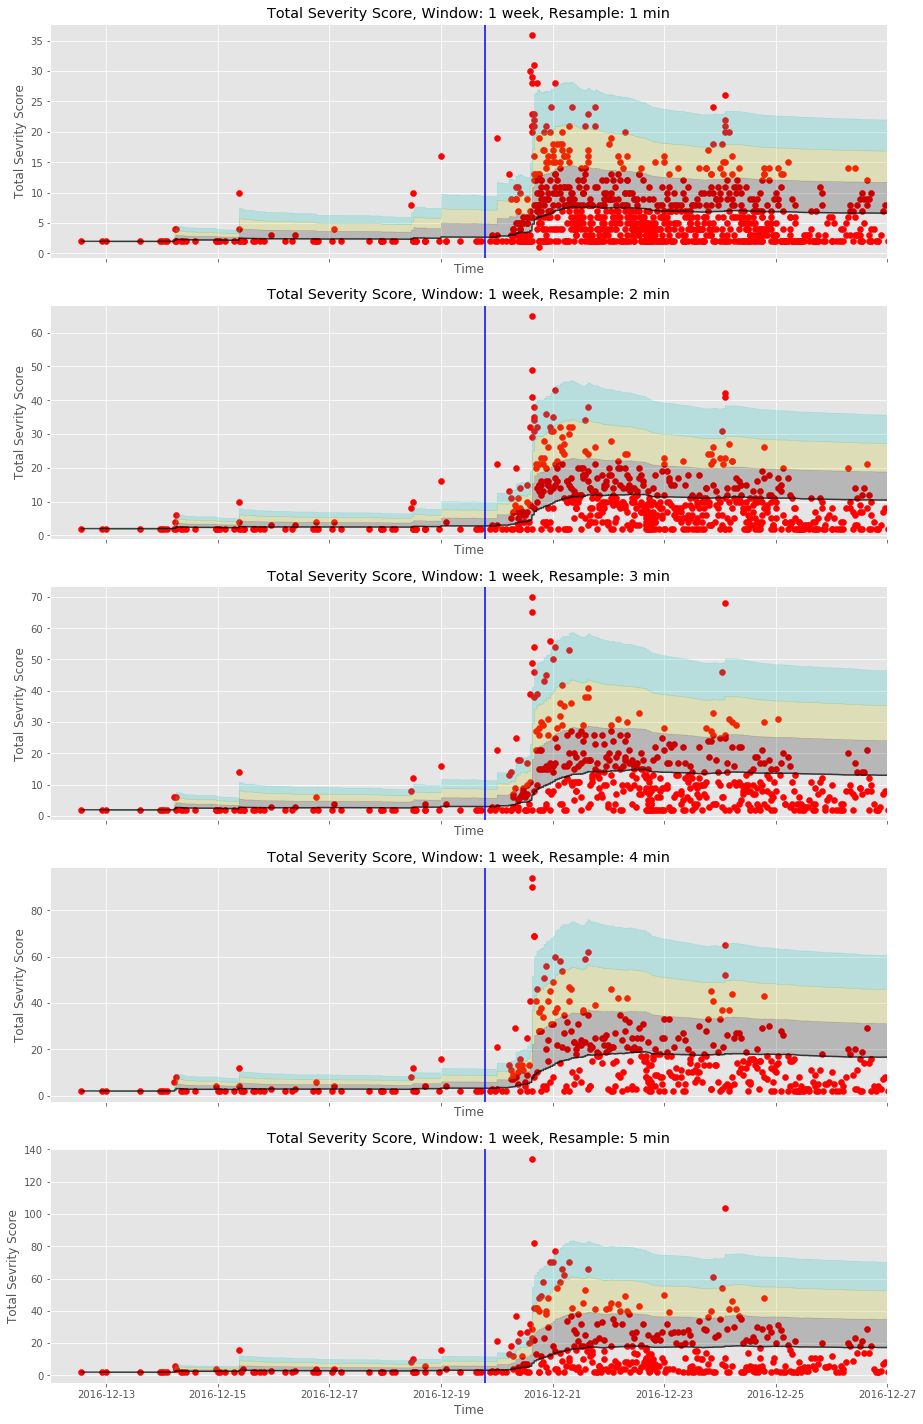

In [65]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for idx, ax in enumerate(axes.flatten()):
    plot_moving_std_trend(
        ax,
        name="Total Severity Score, Window: 1 week, Resample: {} min".format(idx+1),
        data_series=sev_resample_options[idx],
        window=7*24*60/(idx+1)
    )
    ax.axvline(attack_dtg, color="b")
    ax.set_xlim("2016-12-12","2016-12-27")
    ax.set_xlabel("Time")
    ax.set_ylabel("Total Sevrity Score")

In [66]:
for i, resample in enumerate(sev_resample_options):
    anomalies = find_anomalies(resample, window=(7*24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0} minutes
    First Anomaly: {1}
    """.format(i+1, post_attack_anomalies.first_valid_index())


    Resample: 1 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 2 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 3 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 4 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 5 minutes
    First Anomaly: 2016-12-20 00:00:00
    


## Using Sum of Square of Severity Scores

In [67]:
quadratic_ts = pd.Series(
            berlin_df["severity_quadratic"].values,
            index=berlin_df["start_ts"]
            )

quad_one_min = quadratic_ts.resample("T").sum()
quad_two_min = quadratic_ts.resample("2T").sum()
quad_three_min = quadratic_ts.resample("3T").sum()
quad_four_min = quadratic_ts.resample("4T").sum()
quad_five_min = quadratic_ts.resample("5T").sum()

quad_resample_options = [
    quad_one_min,
    quad_two_min,
    quad_three_min,
    quad_four_min,
    quad_five_min
]

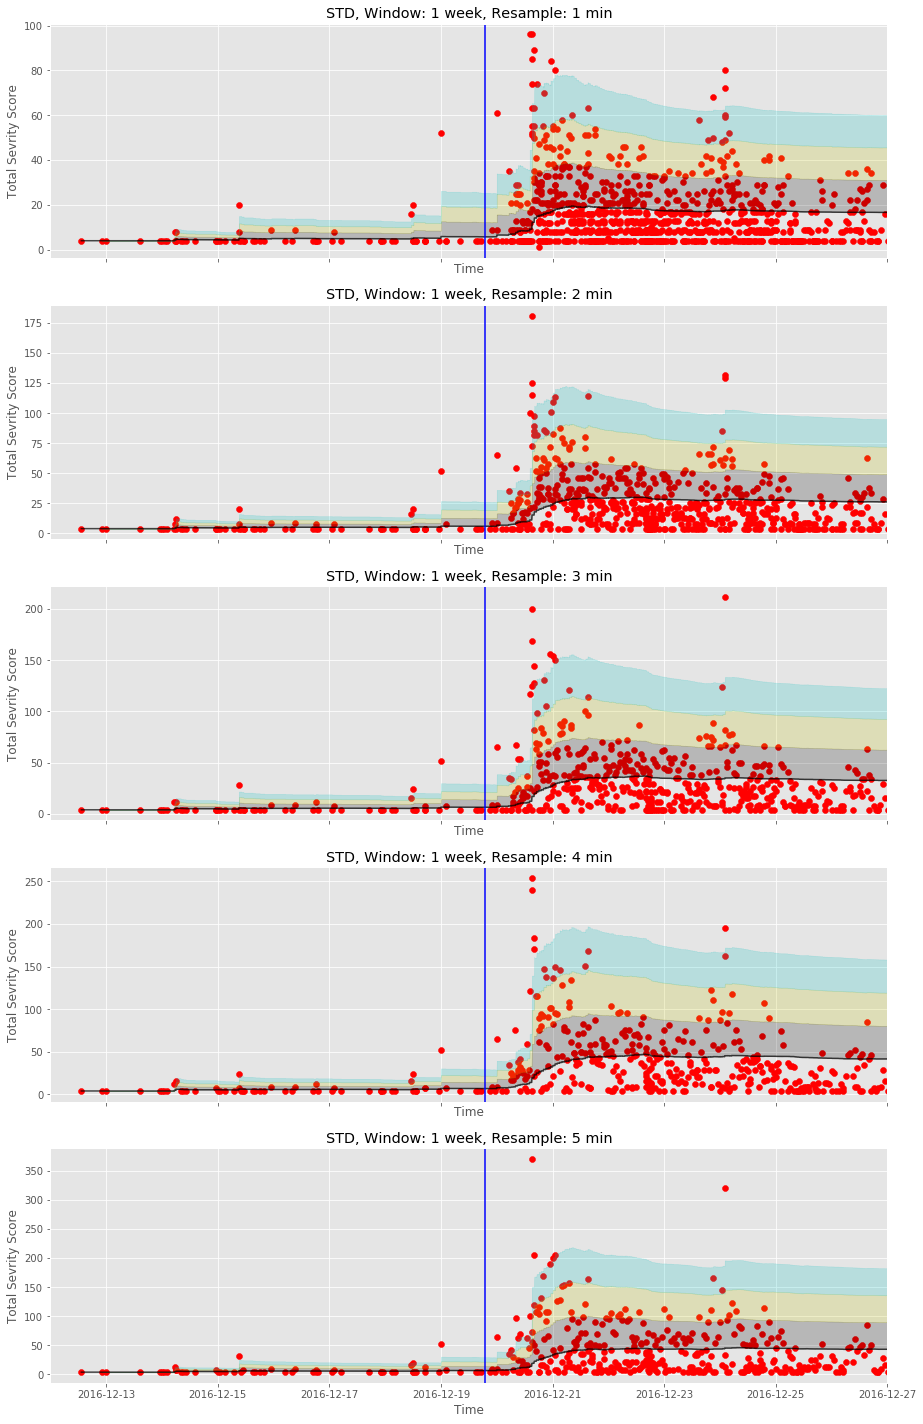

In [68]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for idx, ax in enumerate(axes.flatten()):
    plot_moving_std_trend(
        ax,
        name="STD, Window: 1 week, Resample: {} min".format(idx+1),
        data_series=quad_resample_options[idx],
        window=7*24*60/(idx+1)
    )
    ax.axvline(attack_dtg, color="b")
    ax.set_xlim("2016-12-12","2016-12-27")
    ax.set_xlabel("Time")
    ax.set_ylabel("Total Sevrity Score")

In [69]:
for i, resample in enumerate(quad_resample_options):
    anomalies = find_anomalies(resample, window=(7*24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0} minutes
    First Anomaly: {1}
    """.format(i+1, post_attack_anomalies.first_valid_index())


    Resample: 1 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 2 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 3 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 4 minutes
    First Anomaly: 2016-12-20 00:00:00
    

    Resample: 5 minutes
    First Anomaly: 2016-12-20 00:00:00
    


## Using Natural Log of Sum of Squared Severity Scores

In [70]:
log_one_min = np.log(quadratic_ts.resample("T").sum())
log_two_min = np.log(quadratic_ts.resample("2T").sum())
log_three_min = np.log(quadratic_ts.resample("3T").sum())
log_four_min = np.log(quadratic_ts.resample("4T").sum())
log_five_min = np.log(quadratic_ts.resample("5T").sum())

log_resample_options = [log_one_min, log_two_min, log_three_min, log_four_min, log_five_min]

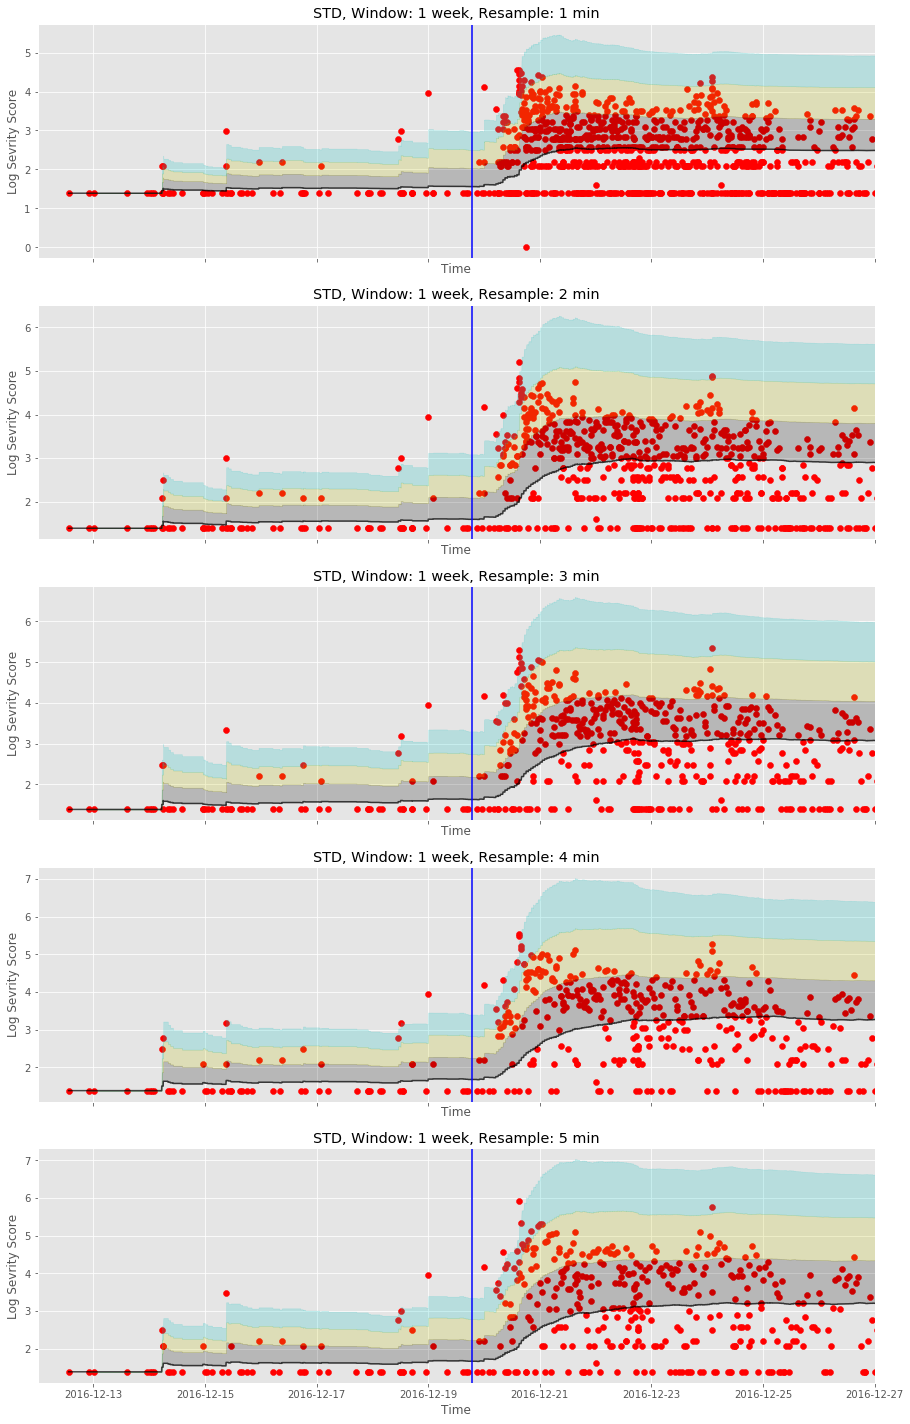

In [71]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for idx, ax in enumerate(axes.flatten()):
    plot_moving_std_trend(
        ax,
        name="STD, Window: 1 week, Resample: {} min".format(idx+1),
        data_series=log_resample_options[idx],
        window=7*24*60/(idx+1)
    )
    ax.axvline(attack_dtg, color="b")
    ax.set_xlim("2016-12-12","2016-12-27")
    ax.set_xlabel("Time")
    ax.set_ylabel("Log Sevrity Score")

In [72]:
for i, resample in enumerate(log_resample_options):
    anomalies = find_anomalies(resample, window=(7*24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0}
    First Anomaly: {1}
    
    """.format(i+1, post_attack_anomalies.first_valid_index())


    Resample: 1
    First Anomaly: 2016-12-19 22:01:00
    
    

    Resample: 2
    First Anomaly: 2016-12-19 22:00:00
    
    

    Resample: 3
    First Anomaly: 2016-12-19 22:00:00
    
    

    Resample: 4
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 5
    First Anomaly: 2016-12-20 00:00:00
    
    


## Using Natural Log of Sum of Exponential Severity Scores

In [73]:
exponential_ts = pd.Series(
            berlin_df["severity_exp"].values,
            index=berlin_df["start_ts"]
            )

exp_one_min = exponential_ts.resample("T").sum()
exp_two_min = exponential_ts.resample("2T").sum()
exp_three_min = exponential_ts.resample("3T").sum()
exp_four_min = exponential_ts.resample("4T").sum()
exp_five_min = exponential_ts.resample("5T").sum()

exp_resample_options = [
    exp_one_min,
    exp_two_min,
    exp_three_min,
    exp_four_min,
    exp_five_min
]

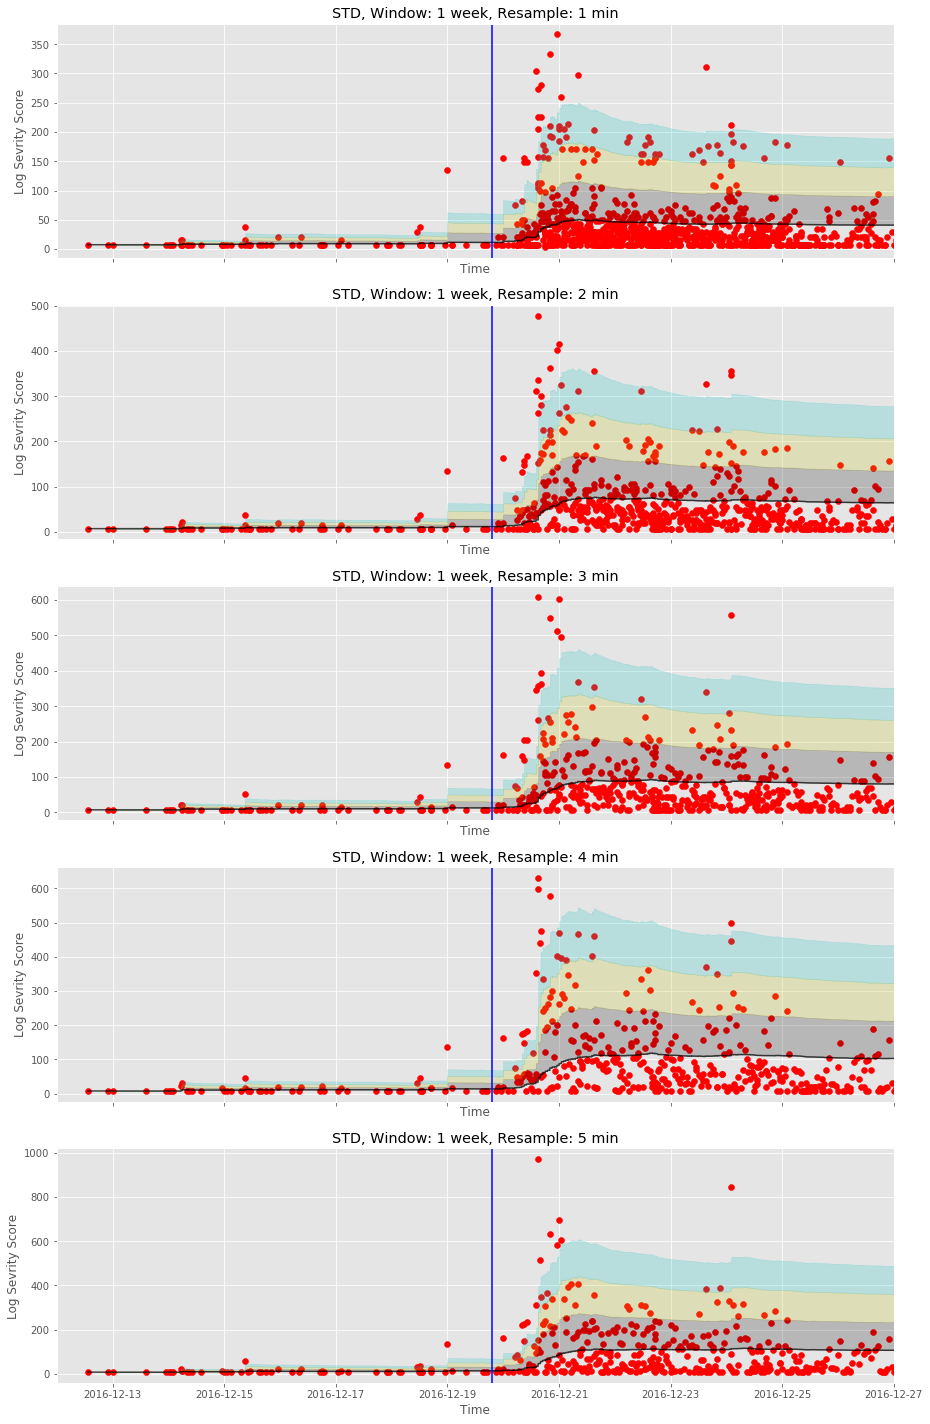

In [74]:
fig, axes = plt.subplots(5, figsize=(15,25), sharex=True)

for idx, ax in enumerate(axes.flatten()):
    plot_moving_std_trend(
        ax,
        name="STD, Window: 1 week, Resample: {} min".format(idx+1),
        data_series=exp_resample_options[idx],
        window=7*24*60/(idx+1)
    )
    ax.axvline(attack_dtg, color="b")
    ax.set_xlim("2016-12-12","2016-12-27")
    ax.set_xlabel("Time")
    ax.set_ylabel("Log Sevrity Score")

In [75]:
for i, resample in enumerate(exp_resample_options):
    anomalies = find_anomalies(resample, window=(7*24*60)/(i+1))
    post_attack_anomalies = anomalies[attack_dtg:]
    print """
    Resample: {0}
    First Anomaly: {1}
    
    """.format(i+1, post_attack_anomalies.first_valid_index())


    Resample: 1
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 2
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 3
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 4
    First Anomaly: 2016-12-20 00:00:00
    
    

    Resample: 5
    First Anomaly: 2016-12-20 00:00:00
    
    


## Initial Post-Attack Reports 

In [66]:
post_attack_df = berlin_df[berlin_df["start_ts"] > attack_dtg]
print post_attack_df.sort_values("start_ts", axis=0)[:20]

             lat        lon  \
68523  52.524370  13.410530   
68745  52.524370  13.410530   
69730  52.524370  13.410530   
70474  52.504884  13.335370   
72156  52.504884  13.335370   
77280  52.504884  13.335370   
76903  52.504884  13.335370   
72095  52.482073  13.389646   
73886  52.504884  13.335370   
69713  52.524370  13.410530   
1027   52.524370  13.410530   
70843  52.524370  13.410530   
71340  52.524370  13.410530   
71561  52.524370  13.410530   
71550  52.524370  13.410530   
71570  52.524370  13.410530   
71554  52.524370  13.410530   
71371  52.524370  13.410530   
71700  52.524370  13.410530   
71741  52.524370  13.410530   

                                                   title          created_on  \
68523  Truck Plows Into Christmas Market in Berlin, I... 2016-12-19 21:02:20   
68745  9 Killed and Many Injured as Truck Drives Into... 2016-12-19 22:02:07   
69730  Berlin outraged at Christmas 'ban' at German s... 2016-12-19 23:16:37   
70474  Death toll rises from